In [18]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from method import IV
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import pandas as pd
import numpy as np
import quantities as pq
import seaborn as sns
from tools_analysis import cch_significance
from tools_plot import plot_psth, fix_figure, savefig, despine, set_style, add_caption
import copy
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
dataa = np.load('results/triple.npz')['data'][()]

In [11]:
winsize_iv = 4
latency_iv = 4

winsize_cch = 3
latency_cch = 3

res = []
chhs = []
N_trials = np.arange(0, 31000, 1000)
N_trials[0] = 100
for N in N_trials:
    ws = [[], []]
    ts = [[], []]
    for n in [0,1]:
        iv = IV(dataa['spiketrains'][n]['times'], 
                dataa['spiketrains'][2]['times'],
                dataa['epoch']['times'][:N],
                winsize=winsize_iv, latency=latency_iv)
        
        spike_trains = [dataa['spiketrains'][n]['times'], 
                        dataa['spiketrains'][2]['times']]
        spike_trains = [s[s <= dataa['epoch']['times'][N-1]] for s in spike_trains]
        pcausal, pfast, bins, cch, cch_s = cch_significance(
                    *spike_trains, limit=15, binsize=1,
                    hollow_fraction=.6, width=10)
        assert len(pcausal) == len(cch)
        
        mask = (bins >= latency_cch) & (bins <= latency_cch + winsize_cch)
        trans_prob = sum(cch[mask] - cch_s[mask]) / len(spike_trains[0])
        ws[n].append(iv.wald)
        ts[n].append(trans_prob)
    res.append(ws)
    chhs.append(ts)
res = np.array(res)
chhs = np.array(chhs)

In [12]:
set_style('article')
t_stop = dataa['status']['time']
spiketrains = [s['times'] for s in dataa['spiketrains']]
names = ['A', 'B', 'C']
colors = sns.color_palette()

In [14]:
xg = N_trials.copy()
xg[0] = 0

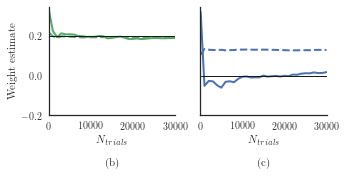

In [24]:
set_style('article')
ylim = [-0.2, 0.35]
xlim = [0, 30000]
fig, (ax_bc, ax_ac) = plt.subplots(1,2, sharey=True)

ax_bc.plot(N_trials, res[:,1], c=colors[1], label='$IV_{BC}$')

ax_bc.plot(N_trials, chhs[:,1], label='$CCH_{BC}$', ls='--', color=colors[1])

ax_bc.plot(xg, .2 * np.ones_like(xg), lw=1, color='k')

ax_bc.set_ylabel('Weight estimate')
ax_bc.set_xlabel('$N_{trials}$')
# plt.legend()
ax_bc.set_ylim(ylim)
ax_bc.set_xlim(xlim)
despine()


ax_ac.plot(N_trials, res[:,0], c=colors[0], label='$IV_{AC}$')

ax_ac.plot(N_trials, chhs[:,0], label='$CCH_{AC}$', ls='--', color=colors[0])

ax_ac.plot(N_trials, np.zeros_like(N_trials), color='k', lw=1, label='GT')

ax_ac.set_xlabel('$N_{trials}$')
# plt.legend()
ax_ac.set_ylim(ylim)
ax_ac.set_xlim(xlim)
despine(yticks=False, left=False, ax=ax_ac)
despine(yticks=True, left=False, ax=ax_bc)
add_caption((ax_bc, ax_ac), vspace=2, start='b')
savefig(fig, 'triple')

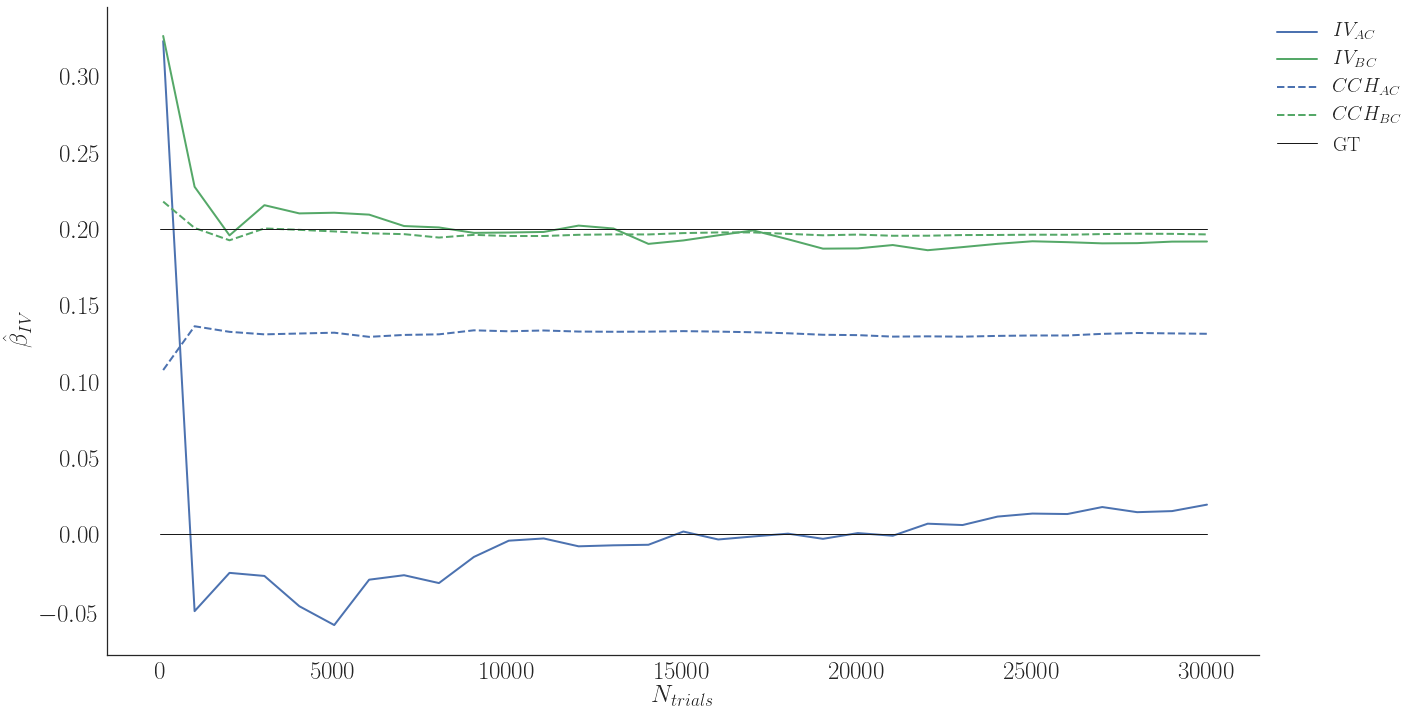

In [8]:
set_style('notebook', w=0.485)
plt.plot(N_trials, res[:,0], label='$IV_{AC}$', color=colors[0])
plt.plot(N_trials, res[:,1], label='$IV_{BC}$', color=colors[1])

plt.plot(N_trials, chhs[:,0], label='$CCH_{AC}$', ls='--', color=colors[0])
plt.plot(N_trials, chhs[:,1], label='$CCH_{BC}$', ls='--', color=colors[1])


plt.plot(xg, np.zeros_like(xg), lw=1, color='k', label='GT')
plt.plot(xg, .2 * np.ones_like(xg), lw=1, color='k')

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.xlabel('$N_{trials}$')
plt.ylabel('$\\hat\\beta_{IV}$')
sns.despine()
fix_figure()
# savefig(plt.gcf(), 'wald_triple')